# Land Usage for Utility Scale PV Power Plants

I received a message from an old friend this afternoon who said, "Random question. How big of site would you guess is required for a 1 megawatt solar field?" To which I responded, in classic Ph.D. fashion, "Well, that's complicated." 

As you might guess, the answer depends heavily on the cell, module, and mounting/tracking technologies used at the power plant. Obviously, a plant built with 25% efficient modules will use less land than a plant built with 15% efficient modules for the same overall capacity. You also need to consider design decisions like [ground cover ratio](https://www.researchgate.net/figure/Ground-coverage-ratio-GCR-is-the-ratio-of-module-area-to-land-area-or-the-ratio-of_fig1_304106060) and many others to exactly estimate this quantity.

The "Suncyclopedia" [states that](http://www.suncyclopedia.com/en/area-required-for-solar-pv-power-plants/) "A simple rule of thumb is to take 100 sqft for every 1kW of solar panels." But to be honest, I did trust that number! So, I did a little more digging. As it turns out, Wikipedia helpfully provides a [list of photovoltaic power stations that are larger than 200 megawatts in current net capacity](https://en.wikipedia.org/wiki/List_of_photovoltaic_power_stations), which includes nameplate capacity and total land usage for most of the listed power plants.

Having never actually scraped data from a Wikipedia table before, I figured this was a great opportunity to try out a new Python skill, while doing a bit of light research and data analysis. I used `requests` and `Beautiful Soup` to extract the table from Wikipedia and `pandas` to turn the raw html data into a table for analysis.

We begin with the imports we'll need:

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

First things first, set up the HTML request, parse the HTML response, and extract the table.

In [2]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_photovoltaic_power_stations').text
soup = BeautifulSoup(website_url, 'lxml')
my_table = soup.find('table', {'class': 'wikitable sortable'})

Tables in Wikipedia tend to have references in the cell text, which is annoying if the cell is supposed to have a float value. Finding and removing the references later can be a hassle, because the references are numeric as is the data we are looking for (and I'm not that proficient at regex). Luckily, `BeautifulSoup` makes searching and modifying HTML trees exceptionally easy. In the cell below, we search all cells in the table and remove all examples of the `reference` class.

In [3]:
for row in my_table.findAll('tr'):
    cells = row.findAll(['th', 'td'])
    for cell in cells:
        references = cell.findAll('sup', {'class': 'reference'})
        if references:
            for ref in references:
                ref.extract()

`pandas` has all for data I/O needs covered, and comes with an HTML reader. We simply convert the HTML tree to a string and pass it to `pandas` to make a data frame out of.

In [4]:
df = pd.read_html(str(my_table), header=0)[0]

Now we just need to clean up some column names and data types. Some of the entries in the `Capacity` column contain an asterisk character (`*`) as explained on the Wikipedia page. As with the references, we need to remove these characters to isolate the numerica data. The second to last line below strips all non-numeric characters from the `Capacity` column.

In [5]:
cols = list(df.columns)
cols[3] = 'Capacity'
cols[4] = 'YearlyEnergy'
cols[5] = 'LandSize'
df.columns = cols
df['Capacity'] = df['Capacity'].str.extract('(\d+)', expand=False)
df = df.astype({'LandSize': float, 'Capacity': float})

And now we have successfully converted the table on Wikipedia to a useable data frame!

In [6]:
df.head()

,Name,Country,Location,Capacity,YearlyEnergy,LandSize,Year,Remarks,Ref
0,Tengger Desert Solar Park,China,37°33′00″N 105°03′14″E﻿ / ﻿37.55000°N 105.05389°E,1547.0,NaN,43.0,2016.0,"1,547 MW solar power was installed in Zhongwei...",NaN
1,Pavagada Solar Park,India,14°05′49″N 77°16′13″E﻿ / ﻿14.09694°N 77.27028°E,1400.0,NaN,53.0,2019.0,"In Karnataka state, total planned capacity 2,0...",NaN
2,Bhadla Solar Park,India,27°32′22.81″N 71°54′54.91″E﻿ / ﻿27.5396694°N 7...,1365.0,NaN,40.0,2018.0,"The park is proposed to have a capacity of 2,2...",NaN
3,Kurnool Ultra Mega Solar Park,India,15°40′53″N 78°17′01″E﻿ / ﻿15.681522°N 78.283749°E,1000.0,NaN,24.0,2017.0,1000 MW operational as of December 2017,NaN
4,Datong Solar Power Top Runner Base,China,40°04′25″N 113°08′12″E﻿ / ﻿40.07361°N 113.1366...,1000.0,NaN,NaN,2016.0,1 GW Phase I completed in June 2016. Total cap...,NaN


And now, let's answer my friend's original question and check if the simple rule of thumb is correct. The data in the table is in terms of MW and square kilometers, so we'll need to change our units to kW and square feet to compare to the given rule of thumb.

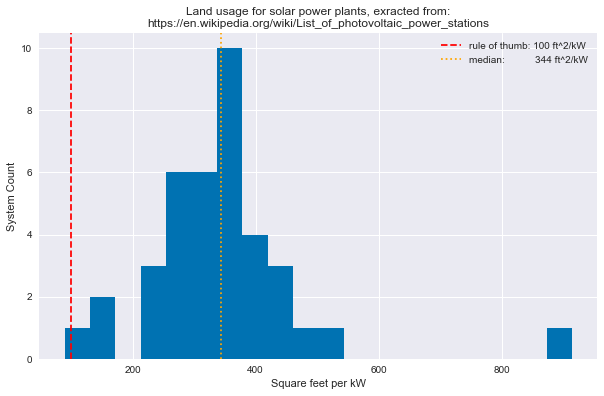

In [7]:
land_usage = (df['LandSize'] * 1.076e+7 / df['Capacity'] / 1000).dropna()
plt.figure(figsize=(10,6))
plt.hist(land_usage, bins=20)
plt.xlabel('Square feet per kW')
plt.ylabel('System Count')
title1 = 'Land usage for solar power plants, exracted from:\n'
title2 = 'https://en.wikipedia.org/wiki/List_of_photovoltaic_power_stations'
plt.title(title1 + title2)
plt.axvline(100, ls='--', color='r', label='rule of thumb: 100 ft^2/kW')
med = np.median(land_usage)
plt.axvline(med, ls=':', color='orange', label='median:           {:.0f} ft^2/kW'.format(med))
plt.legend();

So, we see that the median value for this set of power plants is more than three times larger than the standard rule of thumb!